# AMR-Wind Spectra 2.5x2.5x2.5m case
## sample planes with dx=2.5m

In [1]:
%%capture

import sys
naluhelperdir = '../../../../Postprocessing/utilities/'
sys.path.insert(1, naluhelperdir)

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import matplotlib.pyplot as plt
import numpy as np
import windspectra
import os.path
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
# Average the spectra over multiple locations
# given by locations in planefilelist
def avgSpectraPlanefiles(planefilelist, avgbins, datadir='./', verbose=True):
    # set initial values
    iplane = 0
    all_ulongavgs = []
    lent = 0
    # Loop through and get spectra
    for planefile in planefilelist:
        if not os.path.isfile(datadir+'/'+planefile): continue
        dat       = np.loadtxt(datadir+'/'+planefile)
        t   = dat[:,0]
        z   = dat[:,6]
        u   = dat[:,7]
        v   = dat[:,8]
        w   = dat[:,9]
        if ((iplane != 0) and (lent != len(t))): continue
        if verbose: print("Loaded plane "+planefile)
        ulong, ulat = windspectra.convertUxytoLongLat(u,v)
        all_ulongavgs.append(np.mean(ulong))
        f, Suu      = windspectra.avgWindSpectra(t, ulong, avgbins)
        f, Svv      = windspectra.avgWindSpectra(t, ulat,  avgbins)
        f, Sww      = windspectra.avgWindSpectra(t, w,     avgbins)
        if iplane == 0:
            lent    = len(t)
            favg    = f
            Suu_avg = Suu
            Svv_avg = Svv
            Sww_avg = Sww
        else:
            Suu_avg = Suu_avg + Suu
            Svv_avg = Svv_avg + Svv
            Sww_avg = Sww_avg + Sww
        iplane = iplane+1
        zavg   = np.mean(z)
    # Average the spectra
    Suu_avg = Suu_avg/iplane
    Svv_avg = Svv_avg/iplane
    Sww_avg = Sww_avg/iplane
    print("Averaged over %i planes"%iplane)
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs), zavg

In [3]:
# Define some dicts to save stuff
Suu_avg={}
Svv_avg={}
Sww_avg={}
avgUlong={}
zavg={}
favg={}
allfmax={}
Su_Kai={}
Sv_Kai={}
Sw_Kai={}

In [4]:
# Define data locations and variables
datadirs    = ['./spectra/HHplane_plane0/',
               './spectra/HHplane_plane1/',
               './spectra/HHplane_plane2/',
              ]
#datadir     = './spectra'
#planeprefix = 'testsave_%.1f_%.1f_%.1f.dat'
planeprefix = 'HHplane_%05.0f_%05.0f_%05.0f.dat'

#planenum = 0
#zpt      = 0
szvector = [[0, '20'],  
            [1, '40'], 
            [2, '60'],
           ]
jvector  = np.arange(0,550+1,50) #[0, 100, 200, 300, 400, 500, 600, 700, 800, 900] 
ivector  = np.arange(0,550+1,50) #[0, 100, 200, 300, 400, 500, 600, 700, 800, 900] 

#Averaging bins
avgbins = [[15000.5, 18300],[16650.5, 19950]] #[[20000.5, 23300],[21650.5, 24950]]

# Friction velocity.  Eventually this should be pulled from the ABL stats file
utau     = 0.1573989255269583 #0.15586776602361152 #0.14238698987034834

dx          = 2.5 # Grid spacing
saveprefix  ='AMRWind_Stable05_spectra_dx%04.1f'%dx

In [5]:
# Construct the list of planefiles and average
#s='20'
for izrow, zrow in enumerate(szvector):
    zpt = zrow[0]
    s   = zrow[1]
    datadir = datadirs[izrow]
    planefiles=[]
    for j in jvector:
        for i in ivector:
            planefiles.append(planeprefix%(float(i), float(j), float(zpt)))

    #print(planefiles)
    print(" -- Working on zpt="+repr(zpt)+" z= "+s+" ---")
    favg[s], Suu_avg[s], Svv_avg[s], Sww_avg[s], avgUlong[s], zavg[s] = avgSpectraPlanefiles(planefiles, avgbins, 
                                                                                             datadir=datadir, 
                                                                                             verbose=False)

 -- Working on zpt=0 z= 20 ---
Averaged over 144 planes
 -- Working on zpt=1 z= 40 ---
Averaged over 144 planes
 -- Working on zpt=2 z= 60 ---
Averaged over 144 planes


In [6]:
# Get the equivalent Kaimal spectra
#avgUlong = np.mean(all_ulongavgs)
for izrow, zrow in enumerate(szvector):
    #s='20'
    s = zrow[1]
    print("Avg Ulong = %f zavg = %f"%(avgUlong[s], zavg[s]))
    Su_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s])
    Sv_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.vKaimalconst)
    Sw_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.wKaimalconst)

    fmax = 0.6*avgUlong[s]/(8*np.sqrt(2)*dx)
    allfmax[s]=fmax
    print("fmax = %f"%fmax)
    print("nmax = %f"%(fmax*zavg[s]/utau))

Avg Ulong = 5.002566 zavg = 20.000000
fmax = 0.106120
nmax = 13.484265
Avg Ulong = 5.719726 zavg = 40.000000
fmax = 0.121334
nmax = 30.834697
Avg Ulong = 6.281340 zavg = 60.000000
fmax = 0.133247
nmax = 50.793486


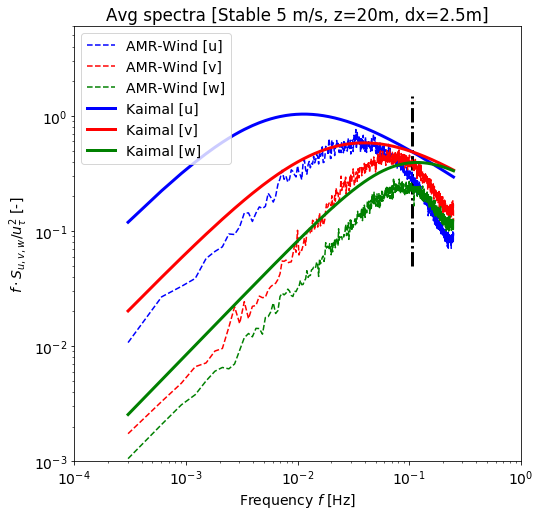

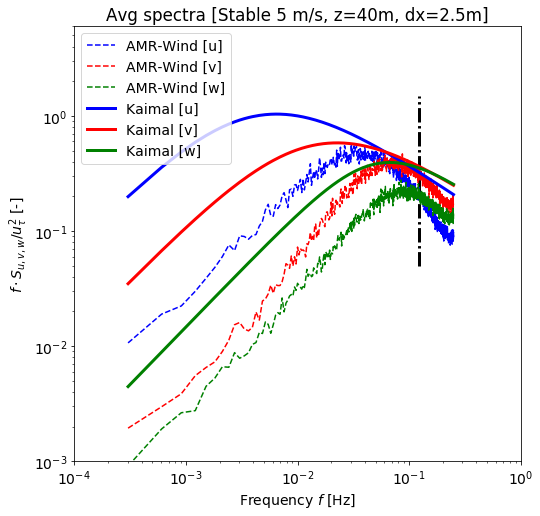

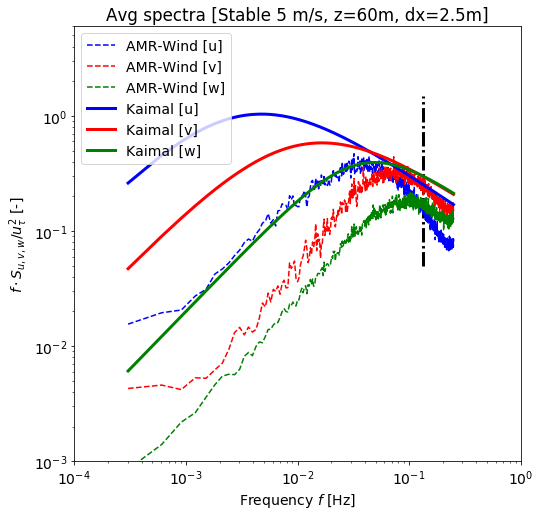

In [7]:
# Plot the longitudinal spectral
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
for izrow, zrow in enumerate(szvector):
    s = zrow[1]
    #s='20'
    plt.figure(figsize=(8,8))
    f=favg[s]
    plt.loglog(f, f*Suu_avg[s]/utau**2, 'b--', label='AMR-Wind [u]')
    plt.loglog(f, f*Svv_avg[s]/utau**2, 'r--', label='AMR-Wind [v]')
    plt.loglog(f, f*Sww_avg[s]/utau**2, 'g--', label='AMR-Wind [w]')

    # Plot Kaimal
    plt.loglog(f, Su_Kai[s],'b', lw=3, label='Kaimal [u]')
    plt.loglog(f, Sv_Kai[s],'r', lw=3, label='Kaimal [v]')
    plt.loglog(f, Sw_Kai[s],'g', lw=3, label='Kaimal [w]')

    # Plot where the spectral cut-off is
    plt.vlines(allfmax[s], 5e-2, 1.5,lw=3, linestyle='-.')

    # Formatting options
    plt.ylim([1E-3, 6]);
    plt.xlim([1E-4, 1]);
    plt.xlabel('Frequency $f$ [Hz]')
    plt.ylabel('$f\cdot S_{u,v,w}/u_{\\tau}^2$ [-]')
    plt.title('Avg spectra [Stable 5 m/s, z=%sm, dx=%2.1fm]'%(s, dx))
    plt.legend(loc='upper left')

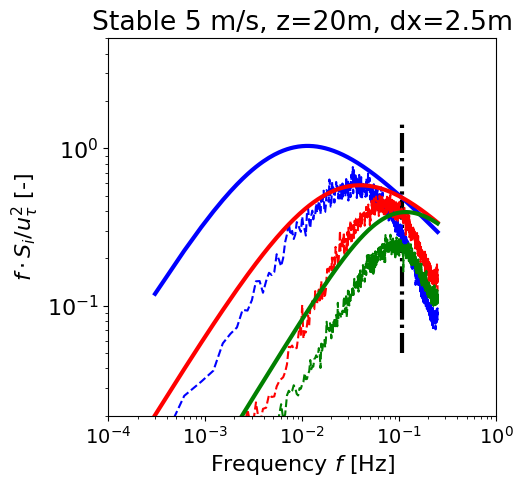

In [8]:
# --- Paper version ---
plt.figure(figsize=(5,5),dpi=100)
plt.rc('font', size=16)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
s='20'
f=favg[s]
plt.loglog(f, f*Suu_avg[s]/utau**2, 'b--', label='Nalu-Wind [u]')
plt.loglog(f, f*Svv_avg[s]/utau**2, 'r--', label='Nalu-Wind [v]')
plt.loglog(f, f*Sww_avg[s]/utau**2, 'g--', label='Nalu-Wind [w]')

# Plot Kaimal
plt.loglog(f, Su_Kai[s],'b', lw=3, label='Kaimal [u]')
plt.loglog(f, Sv_Kai[s],'r', lw=3, label='Kaimal [v]')
plt.loglog(f, Sw_Kai[s],'g', lw=3, label='Kaimal [w]')

# Plot where the spectral cut-off is
plt.vlines(allfmax[s], 5e-2, 1.5,lw=3, linestyle='-.')

# Formatting options
plt.ylim([2E-2, 5]);
plt.xlim([1E-4, 1]);
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('$f\cdot S_{i}/u_{\\tau}^2$ [-]')
plt.title('Stable 5 m/s, z=%sm, dx=%2.1fm'%(s, dx))
#plt.title('Stable 5 m/s, z=%sm'%s)
#plt.title('Avg spectra [Neutral 10 m/s, z=%sm]'%s)
#plt.legend(loc='upper left')

### Save the results

In [9]:
for izrow, zrow in enumerate(szvector):
    s = zrow[1]
    savefile=saveprefix+'_z%s.dat'%s
    savedat=np.vstack((favg[s], Suu_avg[s], Svv_avg[s], Sww_avg[s])).transpose()
    print('Saving %s'%savefile)
    np.savetxt(savefile,savedat,header="f, Suu, Svv, Sww")

Saving AMRWind_Stable05_spectra_dx02.5_z20.dat
Saving AMRWind_Stable05_spectra_dx02.5_z40.dat
Saving AMRWind_Stable05_spectra_dx02.5_z60.dat
